In [1]:
# Importing Necessary Libraries
import cv2
import os
import shutil 
import math
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to remove Duplicate Images in the Dataset
def findDelDuplImg(file_name , file_dir):
    searchedImgPath = os.path.join(file_dir, file_name);
    searchedImage = np.array(cv2.imread(searchedImgPath, 0));
    # Start iterate over all images
    for cmpImageName in os.listdir(file_dir):
        if cmpImageName != file_name:
            # If name is different
            try:
                # Concatenate path to image
                cmpImagePath = os.path.join(file_dir, cmpImageName);
                # Open image to be compared
                cmpImage = np.array(cv2.imread(cmpImagePath, 0))
                # Count root mean square between both images (RMS)
                rms = math.sqrt(mean_squared_error(searchedImage, cmpImage))
            except:
                continue
            # If RMS is smaller than 3 - this means that images are similar or the same
            if rms < 3:
                # Delete Same Image in Dir
                os.remove(cmpImagePath);
                
# Function for Image preprocessing
def processDataset(dataset_src, dataset_dest):
    # Making a Copy of Dataset
    shutil.copytree(src, dest)
    for folder in os.listdir(dest):
        for (index, file) in enumerate(os.listdir(os.path.join(dest, folder)), start = 1):
            filename = f'img_{folder}_{index}.jpg';
            img_src = os.path.join(dest, folder, file);
            img_des = os.path.join(dest, folder, filename);
            # Preprocess the Images
            img = cv2.imread(img_src);
            img = cv2.resize(img, (256, 256));
            img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0);
            img = cv2.blur(img, (2, 2));
            cv2.imwrite(img_des ,img);
            os.remove(img_src);
        for file in os.listdir(os.path.join(dest, folder)):
                # Find duplicated images and delete duplicates.
                findDelDuplImg(file, os.path.join(dest, folder));

# Source Location for Dataset
src = '../input/oral-cancer-lips-and-tongue-images/OralCancer';
# Destination Location for Dataset
dest = './OralCancer';
# Image preprocessing
processDataset(src, dest);

In [3]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;
    
path = "./OralCancer"
DatasetSize = GetDatasetSize(path);
print(DatasetSize);

{'non-cancer': 44, 'cancer': 64}


###  Split the Dataset such that we have 
* 70% for Train Data
* 15% for Validation Data
* 15% for Testing Data

In [4]:
# Function for Creating Train / Validation / Test folders (One time use Only)
 
def TrainValTestSplit(root_dir, classes_dir, val_ratio = 0.15, test_ratio = 0.15):
    for cls in classes_dir:
        # Creating Split Folders
        os.makedirs('train/' + cls)
        os.makedirs('val/' + cls)
        os.makedirs('test/' + cls)

        # Folder to copy images from
        src = root_dir + cls
        
        # Storing the Filenames
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        # Spliting the Files in the Given ratio
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        # Printing the Split Details
        print(cls.upper(),':')
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, 'train/' + cls)

        for name in val_FileNames:
            shutil.copy(name, 'val/' + cls)

        for name in test_FileNames:
            shutil.copy(name, 'test/' + cls)
        print();

# Preforming Train / Validation / Test Split
root_dir = './OralCancer/'              # Dataset Root Folder
classes_dir = ['cancer', 'non-cancer']  # Classes
TrainValTestSplit(root_dir, classes_dir);

CANCER :
Total images:  64
Training:  44
Validation:  10
Testing:  10

NON-CANCER :
Total images:  44
Training:  30
Validation:  7
Testing:  7



### Building Model 


In [5]:
# Importing Keras for Image Classification
import keras
import tensorflow
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


In [6]:
# CNN Model 

model = Sequential() 

# Convolutional Layer with input shape (256,256,3)
model.add(Conv2D(filters=32, kernel_size= (3,3), activation= 'relu', input_shape=(256,256,3)) )

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']  )
 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 128)       7

### Preparing data using data generator 

In [7]:
# Expand the size of dataset with new transformed images from the original dataset using ImageDataGenerator.
train_datagen = image.ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True)
val_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale = 1./255)

In [8]:
train_data = train_datagen.flow_from_directory(directory= "./train", target_size=(256,256), batch_size=32, class_mode = 'binary')

Found 74 images belonging to 2 classes.


In [9]:
train_data.class_indices

{'cancer': 0, 'non-cancer': 1}

In [10]:
val_data = val_datagen.flow_from_directory(directory= "./val", target_size=(256,256), batch_size=32, class_mode = 'binary')

Found 17 images belonging to 2 classes.


In [11]:
test_data = test_datagen.flow_from_directory(directory= "./test", target_size=(256,256), batch_size=32, class_mode = 'binary')

Found 17 images belonging to 2 classes.


In [12]:
# Adding Model check point Callback
mc = ModelCheckpoint(filepath="oral_cancer_best_model.hdf5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto');
call_back = [ mc ];

In [13]:
# Fitting the Model
cnn = model.fit(train_data, 
                  steps_per_epoch = 2, 
                  epochs = 32, 
                  validation_data = val_data, 
                  validation_steps = 1,
                  callbacks = call_back )

Epoch 1/32
2/2 [==============================] - ETA: 0s - loss: 1.0574 - accuracy: 0.5714
Epoch 1: val_accuracy improved from -inf to 0.41176, saving model to oral_cancer_best_model.hdf5
2/2 [==============================] - 10s 6s/step - loss: 1.0574 - accuracy: 0.5714 - val_loss: 0.9467 - val_accuracy: 0.4118
Epoch 2/32
2/2 [==============================] - ETA: 0s - loss: 0.7631 - accuracy: 0.5238
Epoch 2: val_accuracy improved from 0.41176 to 0.58824, saving model to oral_cancer_best_model.hdf5
2/2 [==============================] - 8s 6s/step - loss: 0.7631 - accuracy: 0.5238 - val_loss: 0.6663 - val_accuracy: 0.5882
Epoch 3/32
2/2 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.6250
Epoch 3: val_accuracy did not improve from 0.58824
2/2 [==============================] - 12s 6s/step - loss: 0.6650 - accuracy: 0.6250 - val_loss: 0.6607 - val_accuracy: 0.5882
Epoch 4/32
2/2 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.6429
Epoc

In [14]:
# Loading the Best Fit Model 
model = load_model("./oral_cancer_best_model.hdf5")

### Model Accuracy

In [15]:
# Checking the Accuracy of the Model 
accuracy = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of the model is = {accuracy*100} %")

The accuracy of the model is = 76.47058963775635 %


In [16]:
h =  cnn.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

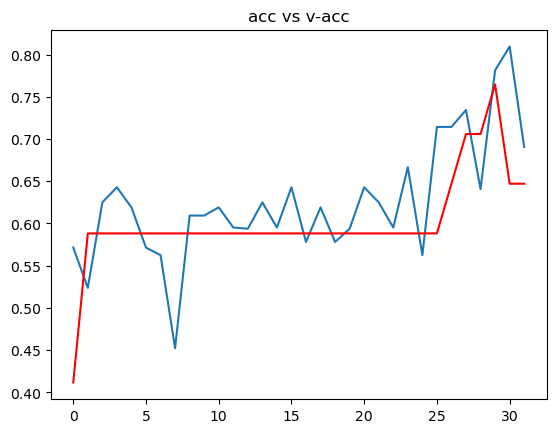

In [17]:
# Ploting Accuracy In Training Set & Validation Set
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

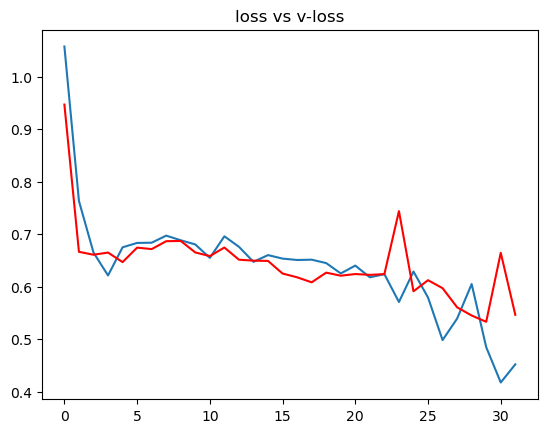

In [18]:
# Ploting Loss In Training Set & Validation Set
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [19]:
def cancerPrediction(path):
    # Loading Image
    img = image.load_img(path, target_size=(256,256))
    # Normalizing Image
    norm_img = image.img_to_array(img)/255
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = (model.predict(input_arr_img) > 0.5).astype(int)[0][0]
    # Printing Model Prediction
    if pred == 0:
        print("Cancer")
    else:
        print("Non-Cancer")
    
# Path for the image to get predictions    
path = "../input/oral-cancer-lips-and-tongue-images/OralCancer/cancer/01960a64-cfe8-444d-bbc5-575c15389a21.jpg"
cancerPrediction(path)

1/1 [==============================] - 0s 184ms/step
Cancer
